## Data Split and Model Baeline

### Setup

In [0]:
from google.colab import drive
import sys, os

%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import re
import time
from contextlib import contextmanager
from sklearn.externals import joblib
%matplotlib inline

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Create a symbolic link to omit issues with whitespace in "My Drive"
!ln -s /content/gdrive/"My Drive"/ /MyDrive

In [0]:
PROJECT_HOME_PATH = os.path.join('/MyDrive', 'LSTM-light')

In [0]:
os.chdir(PROJECT_HOME_PATH)

In [0]:
ls

DATA/                            GloVe/        subwords/
DataSplitAndModelBaseline.ipynb  LSTM.ipynb    TextPreprocessing.ipynb
Embeddings.ipynb                 __pycache__/  utils.py


In [0]:
from utils import *

In [0]:
import numpy as np
import pandas as pd

import os
import time
from contextlib import contextmanager
from sklearn.externals import joblib
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
DATA_PATH = os.path.join(PROJECT_HOME_PATH, 'DATA')

In [0]:
DATA_PATH

'/MyDrive/LSTM-light/DATA'

### Split dataset

Train and test set are stored in separated train, test directories

In [0]:
df_data = joblib.load(os.path.join(DATA_PATH, 'interim', 'quora_mod.dat'))
df_data = df_data.loc[:, ['question_text_mod', 'target']]
df_data.columns = ['text', 'target']
df_data.target = df_data.target.astype(np.uint8)

In [0]:
notes_trn, notes_test, y_trn, y_test = train_test_split(df_data.text, df_data.target, test_size=0.20, random_state=42, stratify=df_data.target)

trn = pd.concat([notes_trn, y_trn], axis=1)
test = pd.concat([notes_test, y_test], axis=1)

In [0]:
trn.to_csv(os.path.join(DATA_PATH, 'train', 'train_notes.csv'), index=False)
test.to_csv(os.path.join(DATA_PATH, 'test', 'test_notes.csv'), index=False)

### Model Baseline

#### Load data

In [0]:
train_notes = pd.read_csv(os.path.join(DATA_PATH, 'train', 'train_notes.csv'))
test_notes = pd.read_csv(os.path.join(DATA_PATH, 'test', 'test_notes.csv'))

notes_trn = train_notes['text']
y_trn = train_notes['target']

notes_test = test_notes['text']
y_test = test_notes['target']


#### TfidfVectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [0]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=20000)

In [0]:
tfidf_vect.fit(notes_trn)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
xtrain_tfidf = tfidf_vect.transform(notes_trn)

In [0]:
xtest_tfidf = tfidf_vect.transform(notes_test)

In [0]:
xtrain_tfidf.shape

(1044397, 20000)

#### Metrics

In [0]:
def calc_fscore(y_true, y_pred):
    print(f'F-score: {f1_score(y_true, y_pred):.4f}')
    
def calc_classRep(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    
def draw_pred_distr(pred_proba):
    plt.hist(pred_proba)
    _ = plt.axvline(x=0.5, color='orange')
    
def calc_conf_matrix(y_true, y_pred):
    
    return pd.DataFrame(confusion_matrix(y_true, y_pred), index=['actual_0', 'actual_1'], columns=['pred_0', 'pred_1'])


def draw_roc_curve(y_true, pred_proba):
    
    fpr, tpr, _ = roc_curve(y_true, pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    

#### Fit model

In [0]:
nb = MultinomialNB()
nb.fit(xtrain_tfidf, y_trn)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
pred_test = nb.predict(xtest_tfidf)

In [0]:
pred_proba = nb.predict_proba(xtest_tfidf)[:, 1]

In [0]:
calc_fscore(y_test, pred_test)

F-score: 0.3885


In [0]:
calc_classRep(y_test, pred_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    244941
           1       0.67      0.27      0.39     16159

   micro avg       0.95      0.95      0.95    261100
   macro avg       0.81      0.63      0.68    261100
weighted avg       0.94      0.95      0.94    261100



In [0]:
calc_conf_matrix(y_test, pred_test)

,pred_0,pred_1
actual_0,242814,2127
actual_1,11750,4409


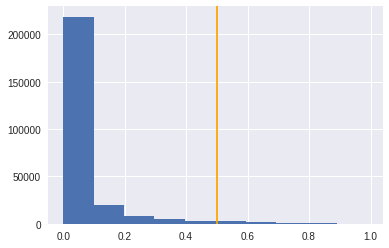

In [0]:
draw_pred_distr(pred_proba)

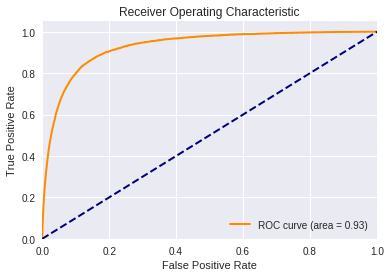

In [0]:
draw_roc_curve(y_test, pred_proba)

In [0]:
lr = LogisticRegression(C=10)
lr.fit(xtrain_tfidf, y_trn)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_test = lr.predict(xtest_tfidf)

In [0]:
pred_proba = lr.predict_proba(xtest_tfidf)[:, 1]

In [0]:
pred_train = lr.predict(xtrain_tfidf)

In [0]:
calc_fscore(y_trn, pred_train)

F-score: 0.5696


In [0]:
calc_fscore(y_test, pred_test)

F-score: 0.5298


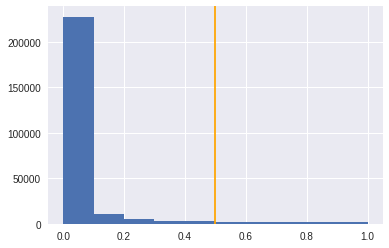

In [0]:
draw_pred_distr(pred_proba)

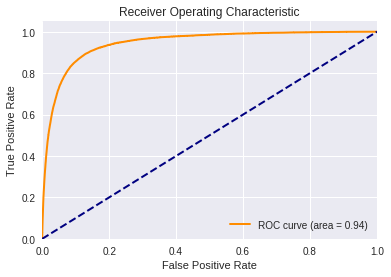

In [0]:
draw_roc_curve(y_test, pred_proba)

In [0]:
lr = LogisticRegression(C=10)

In [0]:
scores = cross_val_score(lr, xtrain_tfidf, y_trn, cv=5, scoring='f1')

print(f'F-score: {scores.mean():.3f}\nstd: {scores.std():.3f}')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F-score: 0.529
std: 0.004


In [0]:
scores

array([0.53349506, 0.52357005, 0.52642429, 0.52866962, 0.53150273])